# Milestone 3 : Predicting the next summer hit !

This notebook is primarly used to print the results of the script ran on the cluster. Please refer to the


In [1]:
from pyspark import SparkContext
import numpy as np

In [2]:
import src.graphing_functions as graphing_functions
import pickle

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import src.analysis_functions as analysis_functions

In [6]:
sc = SparkContext()
DATA_DIR = 'data/'
music_brainz_rdd = sc.pickleFile(DATA_DIR + 'musicbrainz-songs')
analysis_songs_rdd = sc.pickleFile(DATA_DIR + 'analysis-songs')
metadata_songs_rdd = sc.pickleFile(DATA_DIR + 'metadata-songs')

# Analysis of the data

Before doing any step on the data, we need to understand the data we are dealing with. There are different ways of doing. In our case, we are going to print the histograms of the features we are interested in. The histograms will give us a quick an intuitive way of seeing the distribution of the values

### Histograms of data

Using the get_histograms script, we extracted the histograms of the features we were the most interested in. We stored the results as pickle files on the server, and then did the plotting locally.

In [52]:
def load_results(path, filename):
    """
    simple utility function to load pickle files
    """
    with open(path + filename) as in_file:
        data = pickle.load(in_file)
    return data

First we load the global histograms of the main features we are interested in:

In [53]:
histogram_folder = 'cluster_out/histograms/'
histogram_global = {
    'danceability': load_results(histogram_folder, 'danceability-global'),
    'duration': load_results(histogram_folder, 'duration-global'),
    'energy': load_results(histogram_folder, 'energy-global'),
    'hotness': load_results(histogram_folder, 'hotness-global'),
    'key': load_results(histogram_folder, 'key-global'),
    'latitude': load_results(histogram_folder, 'latitude-global'),
    'longitude': load_results(histogram_folder, 'longitude-global'),
    'loudness': load_results(histogram_folder, 'loudness-global'),
    'tempo': load_results(histogram_folder, 'tempo-global'),
    'time_signature': load_results(histogram_folder, 'time_signature-global'),
    'year': load_results(histogram_folder, 'year-global')
}

We now check which histograms are empty. This can happen if either all values are 0, or none of it's elements are numeric values.

In [54]:
for key in histogram_global.keys():
    if histogram_global[key] == (None, None, None):
        print("{0} is an empty histogram".format(key))

energy is an empty histogram
danceability is an empty histogram


We can now print all non empty histograms:

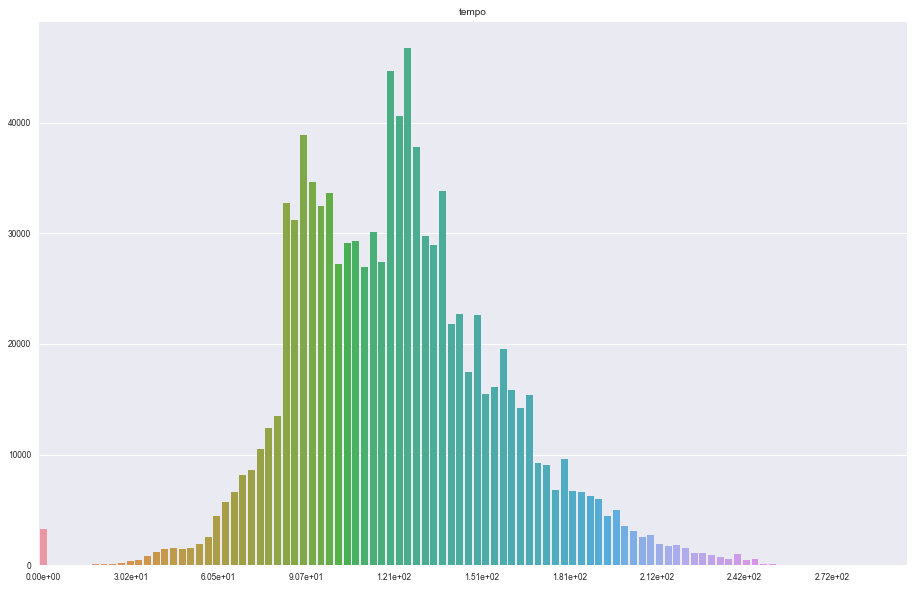

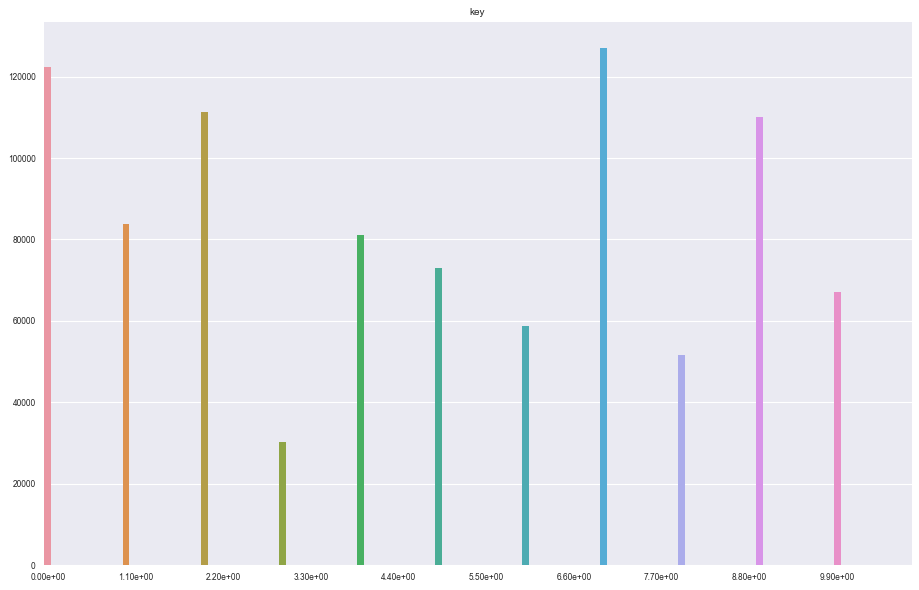

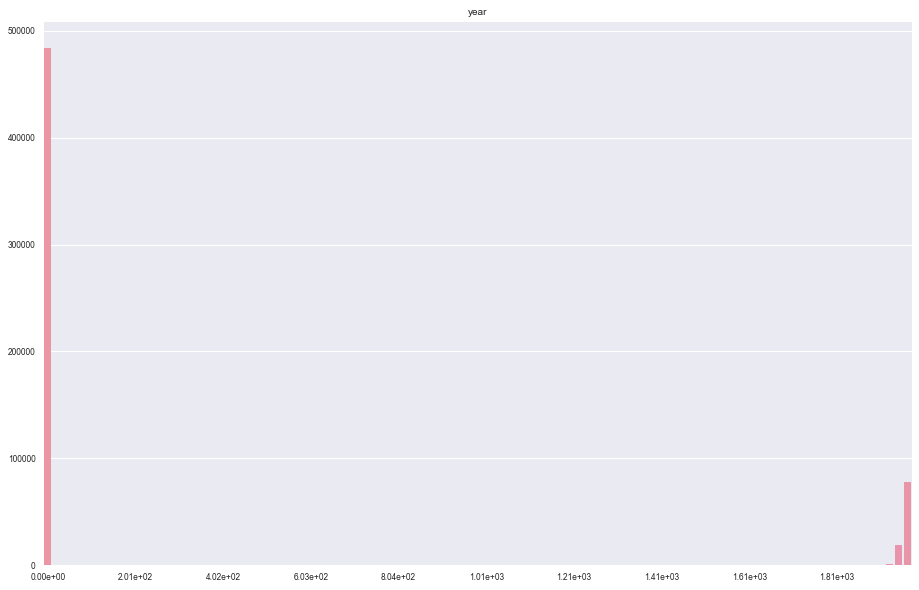

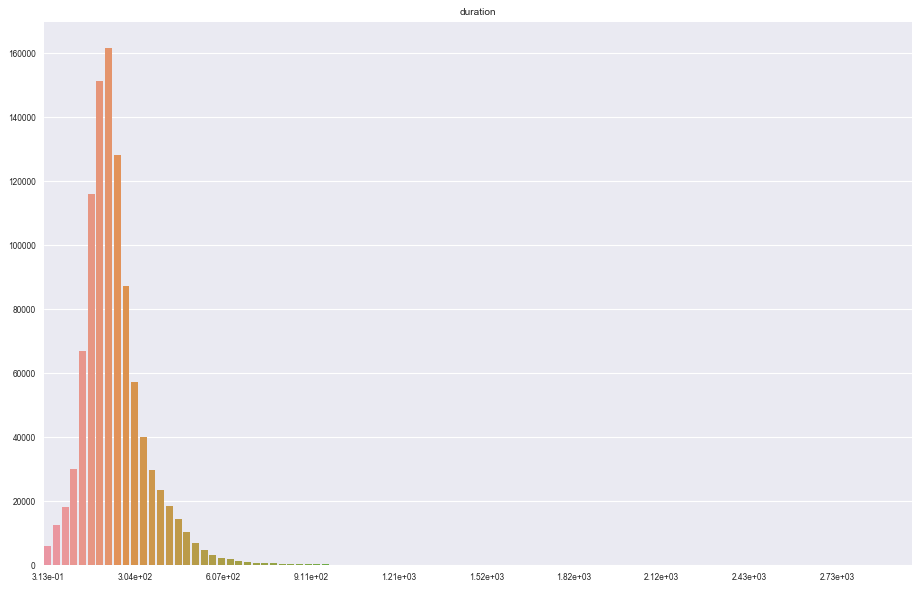

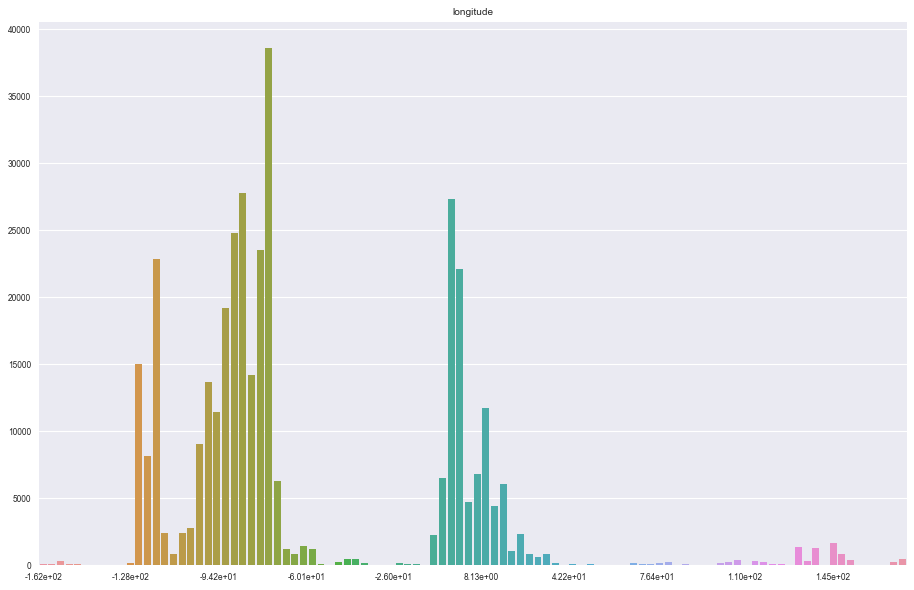

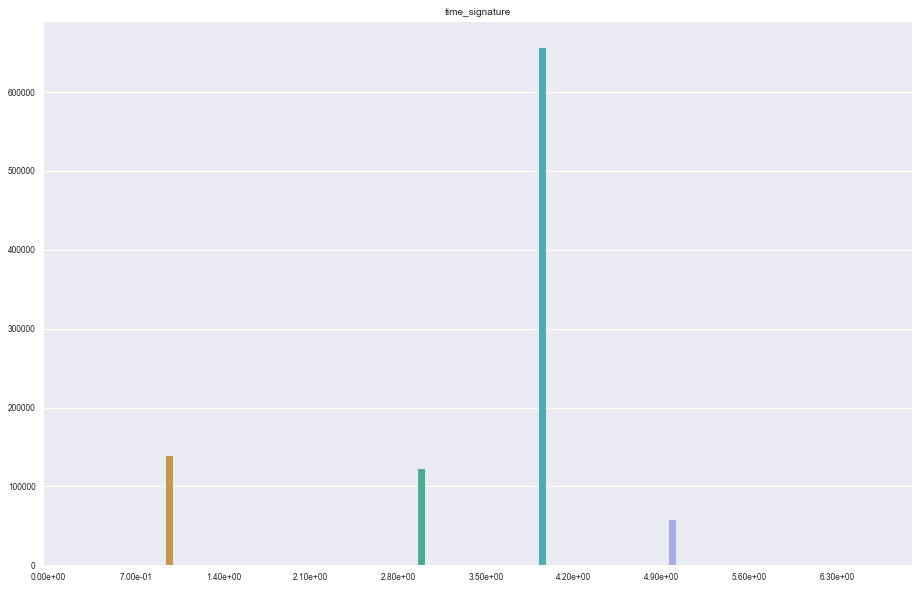

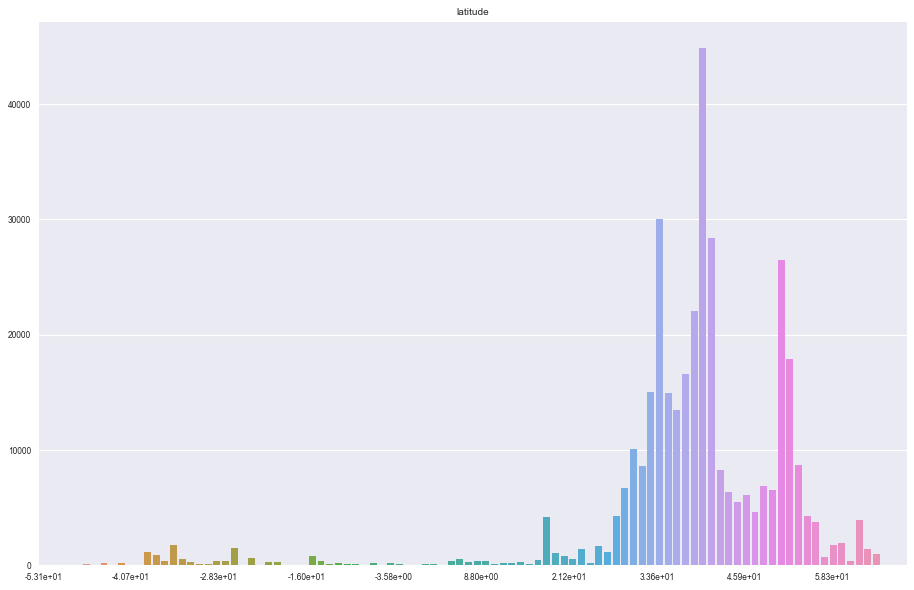

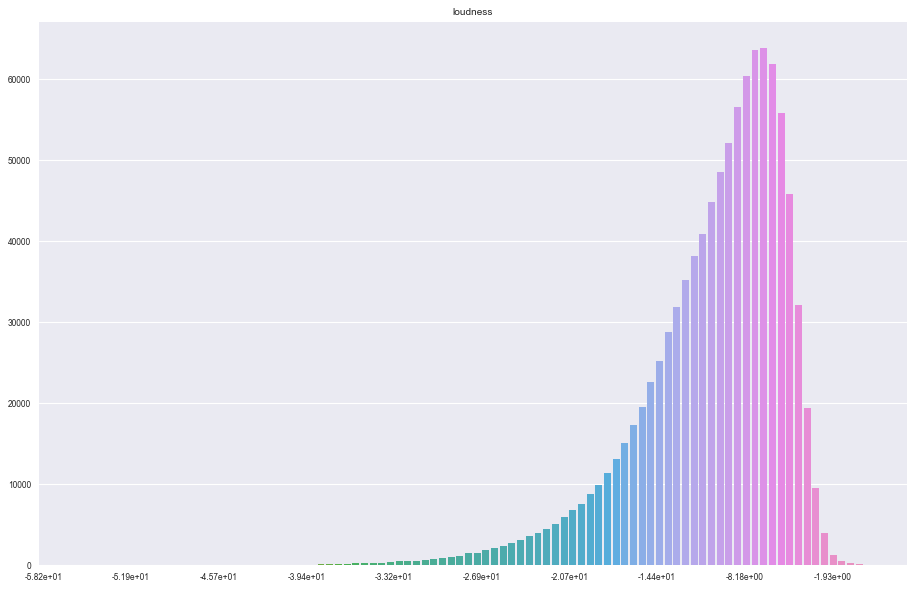

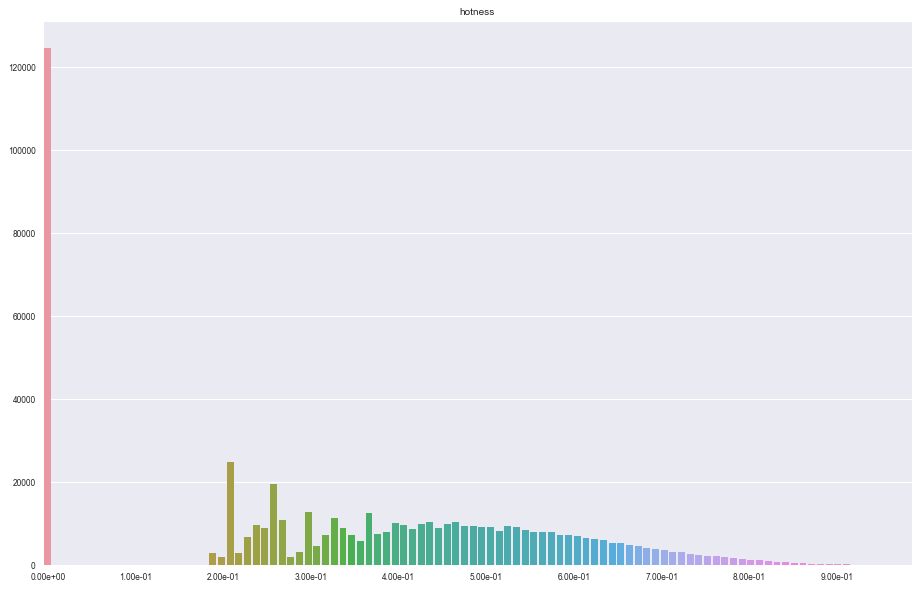

In [55]:
for key in histogram_global.keys():
    if histogram_global[key] != (None, None, None):
        graphing_functions.print_histogram(histogram_global[key][2], title=key, figsize=(14, 9))

Seing the year histogram, we explicit it by re running the script, but by not cunting the 0 values.

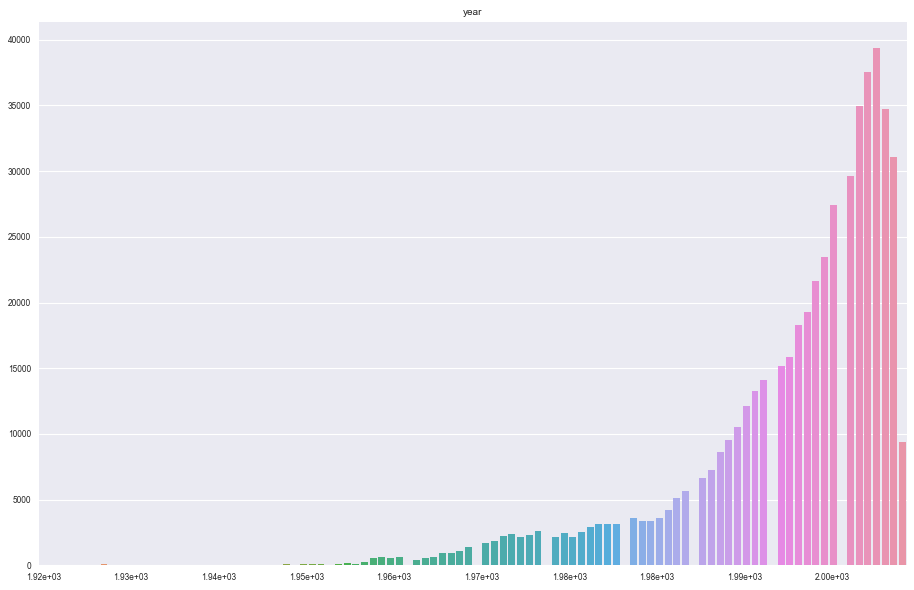

In [63]:
year_nonzero = load_results(histogram_folder, 'year-nonzero')
graphing_functions.print_histogram(year_nonzero[2], figsize=(14, 9), title="year")

We also explicit the hotness histogram by removing the 0 value

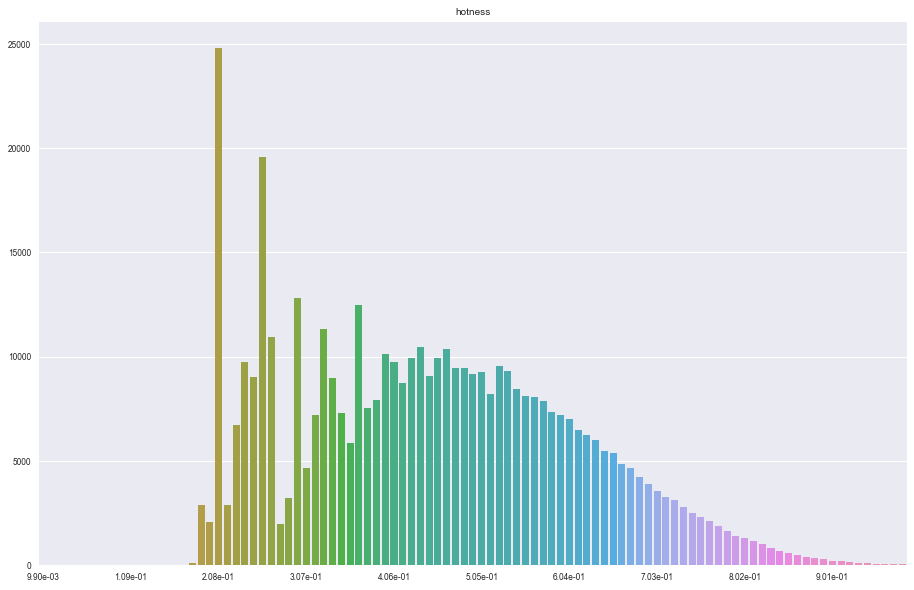

In [64]:
hotness_without_0 = (histogram_global['hotness'][2][0][1:], histogram_global['hotness'][2][1][1:])
graphing_functions.print_histogram(hotness_without_0, figsize=(14, 9), title="hotness")

### Correlations

Using the correlation_calculations in the correlations script, we calculate the correlations between hotness and the previous features

In [68]:
CORRELATION_DIR = 'cluster_out/correlations/'

In [69]:
correlations_global = load_results(CORRELATION_DIR, 'correlations-global')

In [70]:
correlations_global

{'duration': {'corr': -0.019091420674734242, 'nb_elements': 457205},
 'key': {'corr': -0.009422731242725888, 'nb_elements': 402137},
 'latitude': {'corr': 0.05620025940320091, 'nb_elements': 166131},
 'longitude': {'corr': 0.02551165483018819, 'nb_elements': 166131},
 'loudness': {'corr': 0.14315612952335408, 'nb_elements': 457205},
 'tempo': {'corr': 0.023731724658644104, 'nb_elements': 456297},
 'time_signature': {'corr': 0.027484173589606704, 'nb_elements': 457017},
 'year': {'corr': 0.09264981128630362, 'nb_elements': 306298}}

As discuss in the report, we perform stratified sampling using the sampling script, and we plot the points with a scatter plot to check the correlations. This operation is done on the server using the sampled_points function in the correlations file. We also performed the sampling per year to check if some correlation would appear differently depending on the year, but we will not put them here as there is a lot of plots.

In [75]:
sampled_points_loudness = load_results(CORRELATION_DIR, 'sampled-points-loudness')
sampled_points_key = load_results(CORRELATION_DIR, 'sampled-points-key')
sampled_points_latitude = load_results(CORRELATION_DIR, 'sampled-points-latitude')
sampled_points_longitude = load_results(CORRELATION_DIR, 'sampled-points-longitude')
sampled_points_tempo = load_results(CORRELATION_DIR, 'sampled-points-tempo')
sampled_points_time_signature =  load_results(CORRELATION_DIR, 'sampled-points-time_signature')
sampled_points_year = load_results(CORRELATION_DIR, 'sampled-points-year')

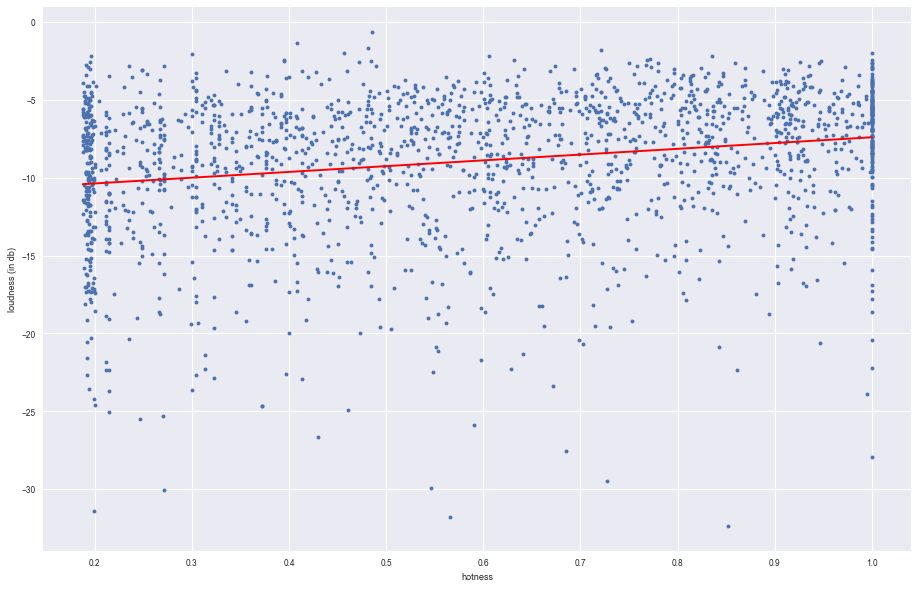

In [78]:
graphing_functions.print_sampled_points(sampled_points_loudness, x_label='hotness', y_label='loudness (in db)', figsize=(14, 9))

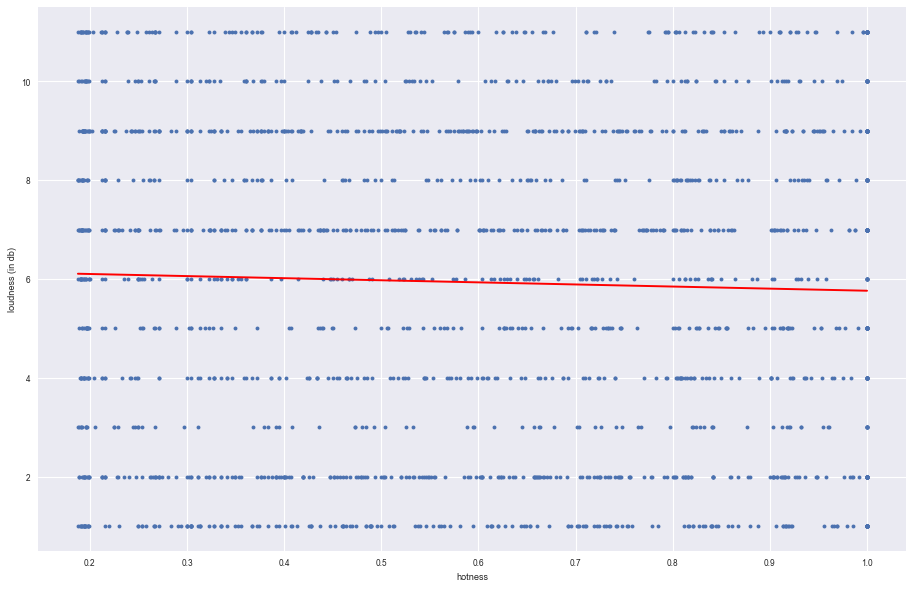

In [79]:
graphing_functions.print_sampled_points(sampled_points_key, x_label='hotness', y_label='loudness (in db)', figsize=(14, 9))

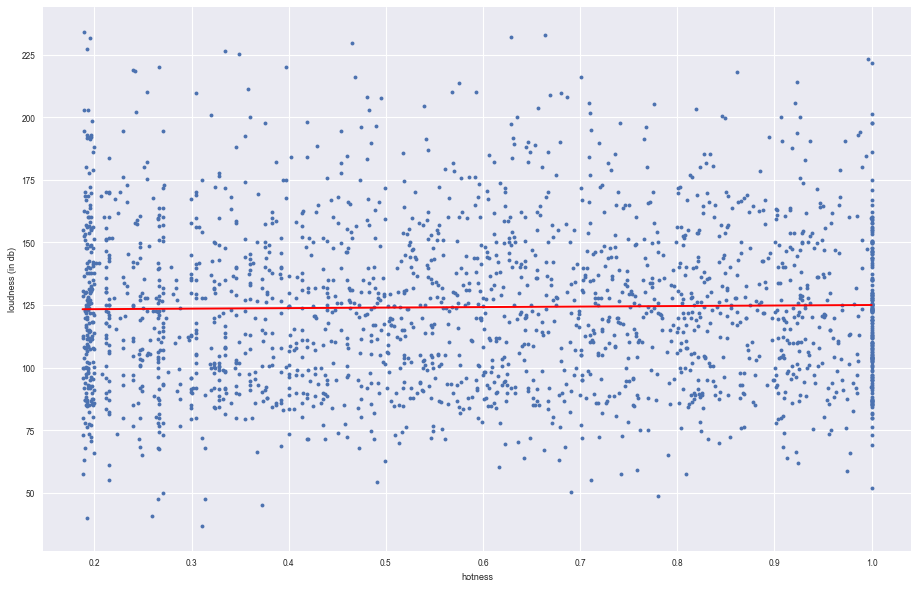

In [81]:
graphing_functions.print_sampled_points(sampled_points_tempo, x_label='hotness', y_label='loudness (in db)', figsize=(14, 9))

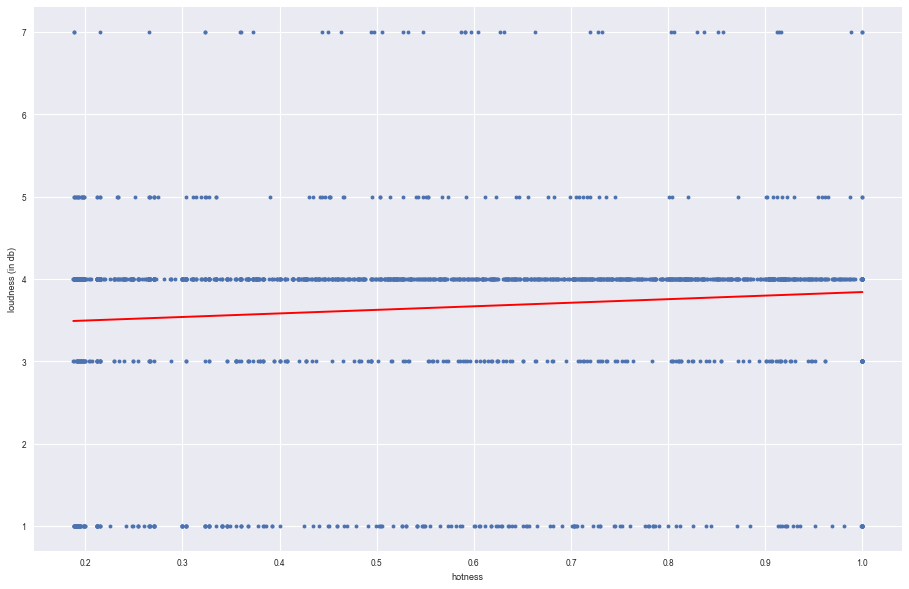

In [82]:
graphing_functions.print_sampled_points(sampled_points_time_signature, x_label='hotness', y_label='loudness (in db)', figsize=(14, 9))

## Analyzing the lyrics

[A detailed discussion of the lyrics analysis is available in the Lyrics_analysis.ipynb](./notebooks/Lyrics_analysis.ipynb).

The original goal of analyzing the lyrics data was to make it a feature in our machine learning algorithm. But it turns out we could extract some interesting data from it.

As mentioned in the report, we generated a word cloud of the total word occurrences over all songs which allows us to easily visualize the most prominent words in the dataset. We also confirmed Zipf's law by observing a Pareto distribution of the word occurrences, like in every word document in existence.

Finally, we generated a graph plotting the evolution of the words' rank compared to the others over the years. This brought us some insights that we could not necessarily determine an emergence of Spanish/French songs or if the data was more in favor of English songs.

# Analyzing the machine learning results

We load the result from the machine learning. We can then print the features along side there value, and sort them with the values. These values correspond to the weights of the linear regression. 

In [84]:
ml_results = load_results('cluster_out/ml/', 'linear_regression_full_30000_0-000007.pickle')

In [85]:
metadata = ['duration', 'key', 'loudness', 'tempo', 'time_signatures']
tags = ['rock', 'electronic', 'pop', 'hip hop', 'jazz', 'alternative rock', 'pop rock', 'united states', 'indie rock', 'alternative', 'electro', 'downtempo', 'indie', 'folk', 'punk', 'house', 'blues', 'techno', 'experimental', 'disco', 'classic rock', 'soul', 'funk', 'folk rock', 'reggae', 'germany', 'hard rock', 'ambient', 'singer-songwriter', 'electronica', 'american', 'ballad', 'country', 'synthpop', 'chill-out', 'acoustic', 'new wave', 'trance', 'soundtrack', 'world', 'female vocalist', 'easy listening', 'soft rock', 'breakbeat', 'rap', 'latin', 'metal', 'dub', 'hardcore', 'heavy metal']
lyrics = [u'love', u'know', u'like', u'just', u'time', u'come', u'oh', u'got', u'la', u'que', u'want', u'let', u'feel', u'make', u'say', u'ca', u'way', u'babi', u'yeah', u'day', u'life', u'away', u'caus', u'need', u'heart', u'gonna', u'look', u'y', u'right', u'night', u'man', u'thing', u'tell', u'think', u'world', u'eye', u'die', u'wanna', u'girl', u'live', u'en', u'tri', u'wo', u'good', u'mind', u'said', u'el', u'littl', u'tu', u'long', u'dream', u'te', u'turn', u'did', u'ya', u'hand', u'everi', u'alway', u'fall', u'se', u'mi', u'run', u'hold', u'noth', u'leav', u'light', u'home', u'wait', u'yo', u'walk', u'hey', u'head', u'believ', u'hear', u'face', u'es', u'gone', u'end', u'le', u'ich', u'lie', u'everyth', u'e', u'better', u'stop', u'someth', u'du', u'befor', u'stay', u'cri', u'gotta', u'alon', u'chang', u'place', u'insid', u'word', u'friend', u'stand', u'boy', u'anoth', u'new', u'play', u'god', u'si', u'realli', u'tonight', u'je', u'peopl', u'left', u'start', u'und', u'hard', u'soul', u'break', u'thought', u'da', u'fuck', u'talk', u'sing', u'burn', u'chorus', u'watch', u'old', u'lost', u'sun', u'pleas', u'danc', u'care', u'na', u'wrong', u'et', u'song', u'lo', u'use', u'hope', u'les', u'o', u'nigga', u'free', u'sky', u'real', u'pain', u'bring', u'true', u'rock', u'por', u'mean', u'yes', u'far', u'blue', u'ai', u'tear', u'ooh', u'high', u'someon', u'dead', u'shit', u'doe', u'dark', u'em', u'close', u'fight', u'big', u'bad', u'wish', u'kiss', u'rain', u'forev', u'rememb', u'kill', u'work', u'di', u'il', u'black', u'year', u'sleep', u'sweet', u'fli', u'star', u'line', u'lose', u'breath', u'open', u'amor', u'door', u'smile', u'mayb', u'becaus', u'ride', u'street', u'lord', u'help', u'che', u'togeth', u'cold', u'everybodi', u'mani', u'money', u'roll', u'sin', u'touch', u'sound', u'ask', u'wonder', u'onc', u'beat', u'al', u'came', u'best', u'una', u'miss', u'ah', u'bodi', u'shine', u'fear', u'blood', u'till', u'pas', u'told', u'non', u'sure', u'hate', u'listen', u'understand', u'save', u'hurt', u'ma', u'son', u'heaven', u'town', u'game', u'knew', u'hell', u'today', u'seen', u'hit', u'round', u'der', u'set', u'deep', u'alright', u'des', u'forget', u'ti', u'hide', u'goe', u'sometim', u'war', u'nicht', u'los', u'happi', u'arm', u'qui', u'dan', u'matter', u'pour', u'fool', u'como', u'ani', u'nobodi', u'beauti', u'late', u'lone', u'music', u'das', u'death', u'truth', u'morn', u'chanc', u'ha', u'wind', u'pass', u'kind', u'para', u'took', u'readi', u'reason', u'crazi', u'heard', u'road', u'woman', u'els', u'learn', u'wall', u'ground', u'young', u'im', u'sit', u'anyth', u'ist', u'shake', u'saw', u'goodby', u'cest', u'step', u'\xe0', u'bitch', u'easi', u'mai', u'broken', u'est', u'sea', u'citi', u'hous', u'wake', u'air', u'angel', u'aliv', u'land', u'white', u'ne', u'grow', u'car', u'fine', u's', u'somebodi', u'guess', u'follow', u'strong', u'lay', u'fade', u'water', u'rise', u'blow', u'room', u'las', u'went', u'voic', u'control', u'kid', u'rest', u'pull', u'del', u'happen', u'reach', u'ein', u'quiero', u'soon', u'red', u'men', u'todo', u'blind', u'scream', u'feet', u'drive', u'hot', u'uh', u'past', u'lot', u't', u'gun', u'solo', u'bout', u'til', u'lover', u'wast', u'everyon', u'laugh', u'gave', u'final', u'drink', u'moon', u'born', u'pay', u'ladi', u'meet', u'parti', u'moment', u'pretti', u'promis', u'cut', u'bed', u'tomorrow', u'veri', u'king', u'pray', u'memori', u'sinc', u'sad', u'earth', u'abov', u'vida', u'hang', u'slow', u'lead', u'apart', u'tout', u'den', u'floor', u'mother', u'drop', u'tire', u'speak', u'dem', u'brother', u'child', u'begin', u'mich', u'noch', u'zu', u'power', u'peac', u'differ', u'goin', u'fast', u'plus', u'mama', u'carri', u'damn', u'esta', u'mas', u'2', u'throw', u'fun', u'eu', u'yall', u'anymor', u'clear', u'ass', u'ring', u'stori', u'empti', u'honey', u'wir', u'ni', u'su', u'ja', u'trust', u'cool', u'mir', u'shadow', u'straight', u'u', u'wit', u'skin', u'plan', u'afraid', u'sign', u'sick', u'cross', u'wild', u'flow', u'answer', u'tree', u'push', u'low', u'faith', u'becom', u'great', u'felt', u'dich', u'catch', u'jesus', u'pick', u'va', u'troubl', u'mon', u'river', u'hay', u'sorri', u'mad', u'kick', u'tight', u'cuz', u'wie', u'perfect', u'um', u'hair', u'hour', u'train', u'sie', u'summer', u'met', u'near', u'stone', u'thank', u'check', u'whoa', u'caught', u'children', u'worri', u'au', u'jag', u'bien', u'knee', u'lyric', u'nos', u'cuando', u'bit', u'comm', u'pero', u'auf', u'nothin', u'wear', u'ser', u'tast', u'er', u'lip', u'comin', u'm\xe1s']

We now print the metadata, the tags and finally the lyrics.

In [89]:
l = [(metadata[i], ml_results[1].weights[i]) for i in range(5)]
l.sort(key=lambda x: x[1])
for el in l:
    print(el[0], str.format('{0:.15f}', el[1]))

('loudness', '-0.000124812082966')
('time_signatures', '0.000069620024505')
('key', '0.000101016701196')
('duration', '0.001209536336227')
('tempo', '0.001977333229592')


In [88]:
l = [(tags[i], ml_results[1].weights[505+i]) for i in range(50)]
l.sort(key=lambda x: x[1])
for el in l:
    print(el[0], str.format('{0:.15f}', el[1]))

('synthpop', '-0.000003517125471')
('germany', '-0.000003139591954')
('house', '-0.000002829409357')
('latin', '-0.000002169430577')
('world', '-0.000001758001572')
('trance', '-0.000001418677170')
('disco', '-0.000001186408689')
('soft rock', '-0.000001099587674')
('pop rock', '-0.000000788231298')
('breakbeat', '-0.000000690751932')
('downtempo', '-0.000000476606317')
('dub', '-0.000000427456277')
('female vocalist', '-0.000000370792899')
('techno', '0.000000001560684')
('easy listening', '0.000000109467960')
('folk rock', '0.000000243577978')
('hip hop', '0.000000321641855')
('ballad', '0.000000532916356')
('reggae', '0.000000722167580')
('electro', '0.000000832187025')
('united states', '0.000000856962213')
('ambient', '0.000001018818705')
('singer-songwriter', '0.000001171266036')
('american', '0.000001335783846')
('hard rock', '0.000001580778933')
('funk', '0.000001839559882')
('chill-out', '0.000001862347303')
('heavy metal', '0.000001991115000')
('electronic', '0.00000226653769

In [86]:
l = [(lyrics[i], ml_results[1].weights[5+i]) for i in range(500)]
l.sort(key=lambda x: x[1])
for el in l:
    print(el[0], str.format('{0:.15f}', el[1]))

(u'que', '-0.000014966945120')
(u'en', '-0.000008113506030')
(u'y', '-0.000007816031945')
(u'la', '-0.000007301114681')
(u'el', '-0.000007132940004')
(u'tu', '-0.000004931594737')
(u'les', '-0.000004903797916')
(u'mi', '-0.000004671546077')
(u'le', '-0.000004118609685')
(u'te', '-0.000003624709861')
(u'si', '-0.000003596656850')
(u'e', '-0.000003362264479')
(u'il', '-0.000003114275022')
(u'pas', '-0.000002959920864')
(u'des', '-0.000002927113065')
(u'lo', '-0.000002772765136')
(u'una', '-0.000002723097824')
(u'di', '-0.000002711264475')
(u'che', '-0.000002669063371')
(u'se', '-0.000002559136823')
(u'je', '-0.000002552012252')
(u'del', '-0.000002328535130')
(u'non', '-0.000002271433012')
(u'al', '-0.000002250600069')
(u'dan', '-0.000002109829442')
(u'ich', '-0.000002051280587')
(u'\xe0', '-0.000002049994631')
(u'qui', '-0.000002043797981')
(u'cest', '-0.000001906535037')
(u'amor', '-0.000001856368901')
(u'das', '-0.000001760498089')
(u'und', '-0.000001734358954')
(u'es', '-0.00000172236